In [50]:
import numpy as np
import keras
from keras import layers

keras.utils.set_random_seed(42)

In [51]:
# Split the training across the different clients
# splittiamo in modo in cui ogni classe è vista solamente da un worker.

num_classes = 10
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize between 0..1
x_train = x_train / 255
x_test = x_test / 255

# Expand representation 28x28x1 (expand the last number nchannels)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [52]:
# da 0 alla fine con stride 3
x_train_client1 = x_train[0:-1:3, :, :, :]
y_train_client1 = y_train[0:-1:3]
x_train_client1 = x_train_client1[y_train_client1 > 5]
y_train_client1 = y_train_client1[y_train_client1 > 5]

# da 1 alla fine con stride 3
x_train_client2 = x_train[1:-1:3, :, :, :]
y_train_client2 = y_train[1:-1:3]
x_train_client2 = x_train_client2[y_train_client2 <= 5]
y_train_client2 = y_train_client2[y_train_client2 <= 5]

# da 2 alla fine con stride 3
x_train = x_train[2:-1:3, :, :, :]
y_train = y_train[2:-1:3]

# i 3 dataset saranno 

print(x_train_client1.shape, x_train_client2.shape, x_train.shape)
print(y_train_client1.shape, y_train_client2.shape, y_train.shape)

(7990, 28, 28, 1) (12004, 28, 28, 1) (19999, 28, 28, 1)
(7990,) (12004,) (19999,)


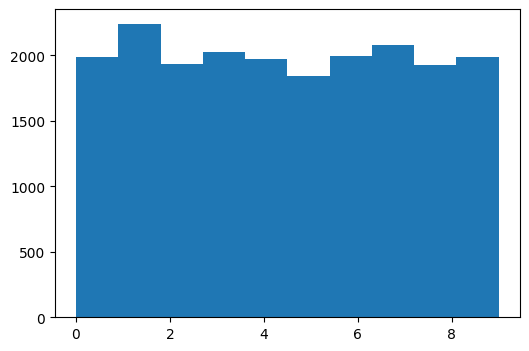

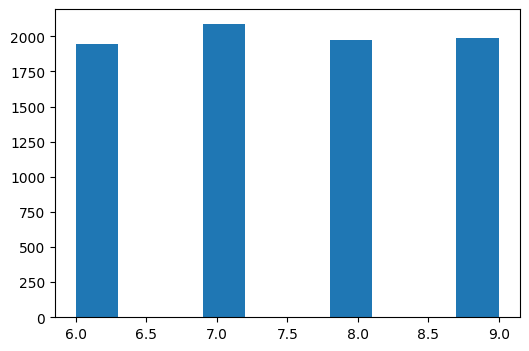

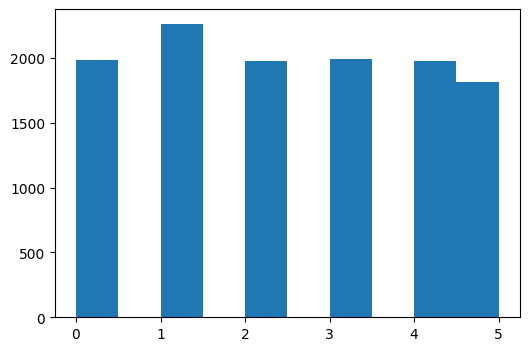

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(y_train, bins=10)
plt.show()


plt.figure(figsize=(6,4))
plt.hist(y_train_client1, bins=10)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(y_train_client2, bins=10)
plt.show()

In [54]:
y_train_client1 = keras.utils.to_categorical(y_train_client1, num_classes)
y_train_client2 = keras.utils.to_categorical(y_train_client2, num_classes)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [55]:
model_central = keras.Sequential([
	keras.Input(shape=(28,28,1)),
	layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
	layers.MaxPooling2D(pool_size=(2,2)),
	layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
	layers.MaxPooling2D(pool_size=(2,2)),
	layers.Flatten(),
	layers.Dropout(0.5),
	layers.Dense(num_classes, activation='softmax')
])

model_central.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
batch_size = 128
epochs = 5

model_central.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Check the performance before training
score = model_central.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: ", score[1])

Test Accuracy:  0.11590000241994858


Simulate federated learning on the same machine by training separately and the aggregating results

In [57]:
# Create the models of the clients 
# Potenzialmente avranno pesi diversi perché abbiamo appena ricreato da 0, quindi copiamo i pesi della rete originale
model_client1 = keras.models.clone_model(model_central)
model_client2 = keras.models.clone_model(model_central)

model_client1.set_weights(model_central.get_weights())
model_client2.set_weights(model_central.get_weights())


In [58]:
model_client1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_client1.fit(x_train_client1, y_train_client1, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4870 - loss: 1.3903 - val_accuracy: 0.9537 - val_loss: 0.1455
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9188 - loss: 0.2301 - val_accuracy: 0.9750 - val_loss: 0.0747
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9575 - loss: 0.1312 - val_accuracy: 0.9837 - val_loss: 0.0546
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9669 - loss: 0.1017 - val_accuracy: 0.9887 - val_loss: 0.0413
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9725 - loss: 0.0877 - val_accuracy: 0.9900 - val_loss: 0.0358


In [59]:
model_client2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_client2.fit(x_train_client2, y_train_client2, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5635 - loss: 1.2587 - val_accuracy: 0.9625 - val_loss: 0.1264
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9508 - loss: 0.1536 - val_accuracy: 0.9775 - val_loss: 0.0732
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9704 - loss: 0.0956 - val_accuracy: 0.9808 - val_loss: 0.0591
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9763 - loss: 0.0698 - val_accuracy: 0.9817 - val_loss: 0.0498
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.0578 - val_accuracy: 0.9850 - val_loss: 0.0444


In [60]:
score = model_client1.evaluate(x_test, y_test, verbose=0)
print("Accuracy client 1: ", score[1])

score = model_client2.evaluate(x_test, y_test, verbose=0)
print("Accuracy client 2: ", score[1])

Accuracy client 1:  0.38929998874664307
Accuracy client 2:  0.5963000059127808


### Aggregation
One single model that should have better accuracy than both models.
Cooperation should achieve a better model than the local models alone.

In [61]:
# FedAVG algorithm (easier version)

models = (model_client1, model_client2)
weights = [model.get_weights() for model in models]

fedavg_weights = [(w1+w2)/2 for w1, w2 in zip(*weights)]
model_central.set_weights(fedavg_weights)

# Facciamo la media dei pesi dei due client.
# Nell'algoritmo originale la media era anche pesata sul numero di dati di ogni client

In [62]:
score = model_central.evaluate(x_test, y_test, verbose=0)
print("Accuracy aggregated", score[1])

Accuracy aggregated 0.9014000296592712


In questo caso funziona bene perché entrambi i client usano lo stesso modello generato all'interno del central

Ma se invece inizializzassimo separatamente i due modelli le performance sarebbero molto peggiori

In [63]:
model_client1 = keras.Sequential([
	keras.Input(shape=(28,28,1)),
	layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
	layers.MaxPooling2D(pool_size=(2,2)),
	layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
	layers.MaxPooling2D(pool_size=(2,2)),
	layers.Flatten(),
	layers.Dropout(0.5),
	layers.Dense(num_classes, activation='softmax')
])

model_client2 = keras.Sequential([
	keras.Input(shape=(28,28,1)),
	layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
	layers.MaxPooling2D(pool_size=(2,2)),
	layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
	layers.MaxPooling2D(pool_size=(2,2)),
	layers.Flatten(),
	layers.Dropout(0.5),
	layers.Dense(num_classes, activation='softmax')
])

model_client1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_client1.fit(x_train_client1, y_train_client1, batch_size=batch_size, epochs=epochs, validation_split=0.1)

model_client2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_client2.fit(x_train_client2, y_train_client2, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model_client1.evaluate(x_test, y_test, verbose=0)
print("Accuracy client 1: ", score[1])

score = model_client2.evaluate(x_test, y_test, verbose=0)
print("Accuracy client 2: ", score[1])

# FedAVG algorithm (easier version)

models = (model_client1, model_client2)
weights = [model.get_weights() for model in models]

fedavg_weights = [(w1+w2)/2 for w1, w2 in zip(*weights)]
model_central.set_weights(fedavg_weights)

# Facciamo la media dei pesi dei due client.
# Nell'algoritmo originale la media era anche pesata sul numero di dati di ogni client

score = model_central.evaluate(x_test, y_test, verbose=0)
print("Accuracy aggregated", score[1])

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.5395 - loss: 1.2815 - val_accuracy: 0.9637 - val_loss: 0.1370
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9248 - loss: 0.2247 - val_accuracy: 0.9787 - val_loss: 0.0685
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9583 - loss: 0.1268 - val_accuracy: 0.9825 - val_loss: 0.0501
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9704 - loss: 0.0908 - val_accuracy: 0.9900 - val_loss: 0.0382
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9768 - loss: 0.0793 - val_accuracy: 0.9887 - val_loss: 0.0336
Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5561 - loss: 1.2999 - val_accuracy: 0.9592 - val_loss: 0.1323
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9491 - loss: 0.1648 - val_accuracy: 0.9800 - val_loss: 0.0749
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9760 - loss: 0.0851 - val_accuracy: 0.9808 - val_loss: 0.058